In [225]:
import nltk
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk.tokenize as tok
import string
import collections
import seaborn as sns
from nltk.corpus import brown
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB 
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

**PART 1 – Conditional frequency distributions (35 pts)**

a. Conduct a similar experiment as the one mentioned above with the genres: news, religion, 
government, fiction, romance as conditions, and occurrences of the words: he, she, her, him, as events. Make a table of the conditional frequencies and deliver code and table.
Note: you may use the tools from NLTK or create a Pandas dataframe, whichever you prefer.

In [226]:
cfd = nltk.ConditionalFreqDist((genre, word) for genre in brown.categories() 
                               for word in brown.words(categories=genre))
genres = ["news", "religion", "government", "fiction", "romance"]
pronouns = ["he", "him", "she", "her"]

# Table of conditional frequencies
cfd.tabulate(conditions=genres, samples = pronouns)

            he him she her 
      news 451  93  42 103 
  religion 137  60  10   8 
government 120  25   0   3 
   fiction 813 375 280 397 
   romance 702 339 496 651 


b. Describe your results. How does gender vary across genres?

By looking at the data, we can see that, for both religion and government, the most used pronouns are the masculine ones, with just a few cases of feminine pronouns, especially for the government sector. Focusing on news, the masculine pronouns still prevails, but the difference is less than in the previous cases. We can also notice that, in fiction and romance, the feminine pronouns finally increase their frequency, reaching high levels, especially in romance. In these two genres, the masculine pronuons still prevales, but with a smaller difference than for the other genres.

As a conclusion, the masculine pronouns are more frequent than the feminine ones across all genres. Moreover, it can be noticed that the relative frequency of $\textit{her}$ with respect to $\textit{she}$ seems higher than the relative frequency of $\textit{him}$ with respect to $\textit{he}$.

Hypothesis: The relative frequency of the object form, her, of the feminine personal pronoun (she or 
her) is higher than the relative frequency of the object form, him, of the masculine personal pronoun, (he 
or him).


c. First, consider the complete Brown corpus. Construct a conditional frequency distribution, which 
uses gender as condition, and for each gender counts the occurrences of nominative forms (he, 
she) and object forms (him, her). Report the results in a two-by-two table. 

In [227]:
nom = ["he", "she"]
obj = ["him", "her"]
text = brown.words()

cdf = nltk.ConditionalFreqDist()

# Count the frequency of nominative and objective form according to gender
for word in text:
    if word.lower() in nom[0]:
        cdf["Male"]["Nominative form"] += 1
    elif word.lower() in nom[1]:
        cdf["Female"]["Nominative form"] += 1
    elif word.lower() in obj[0]:
        cdf["Male"]["Objective form"] += 1
    elif word.lower() in obj[1]:
        cdf["Female"]["Objective form"] += 1
        
cdf.tabulate()

       Nominative form  Objective form 
Female            2884            3074 
  Male            9611            7805 


Then calculate the relative frequency of her from she or her and compare to the relative frequency of him from he or him. Report the numbers. Submit table, numbers and code you used.

In [228]:
relative_her = cdf["Female"]["Objective form"]/(cdf["Female"]["Objective form"] +
                                                cdf["Female"]["Nominative form"])
print("Relative frequency of \"her\" from \"she\" or \"her\":", relative_her)

relative_him = cdf["Male"]["Objective form"]/(cdf["Male"]["Objective form"] +
                                              cdf["Male"]["Nominative form"])
print("Relative frequency of \"him\" from \"he\" or \"him\":", relative_him)

Relative frequency of "her" from "she" or "her": 0.5159449479691172
Relative frequency of "him" from "he" or "him": 0.44815112540192925


It is tempting to conclude from this that the object form of the feminine pronoun is relatively more 
frequent than the object form of the masculine pronoun. Beware, however, that her is not only the 
feminine equivalent of him, but also of his. So what can we do?

Luckily, the Brown corpus is annotated with part-of-speech tags, and we can use these tags to distinguish 
the two functions of her.

d. Use the tagged Brown corpus to count the occurrences of she, he, her, him as personal pronouns and her, his, hers as possessive pronouns. Report the results in a two-ways table.


In [187]:
wordlist = brown.tagged_words()
personal = ["she", "he", "her", "him"]
possessive = ["her", "his", "hers"]
d = {"Personal pronouns": {"she": 0, "he": 0, "her" : 0, "him" : 0}, 
     "Possessive pronouns": {"her" : 0, "his" : 0, "hers" : 0}}

# Update the values in the dictionary according to the frequency of the pronouns
for word, tag in wordlist:
    if tag == "PPS" or tag == "PPO":
        if word.lower() in personal:
            d["Personal pronouns"][word.lower()] += 1
    if tag == "PP$$" or tag == "PP$":
        if word.lower() in possessive:
            d["Possessive pronouns"][word.lower()] += 1

# Transform in dataframe format
df_pronouns = pd.DataFrame.from_dict(d)
df_pronouns = df_pronouns.fillna(0)
df_pronouns

,Personal pronouns,Possessive pronouns
she,2857.0,0.0
he,9541.0,0.0
her,1107.0,1925.0
him,2614.0,0.0
his,0.0,6983.0
hers,0.0,16.0


e. We can now correct the numbers from point (b) above. What percentage of the feminine 
personal pronoun occurs in nominative form and in object form? What are the respective
percentages for the masculine personal pronoun?

In [199]:
pers_nom = df_pronouns.loc["she", "Personal pronouns"]*100/(
    df_pronouns.loc["she"] + df_pronouns.loc["her"] + 
    df_pronouns.loc["hers"]).loc["Personal pronouns"]
print("Percentage of the feminine personal pronoun in nominative form:", pers_nom, "%.")

pers_obj = df_pronouns.loc["her", "Personal pronouns"]*100/(
    df_pronouns.loc["she"] + df_pronouns.loc["her"] + 
    df_pronouns.loc["hers"]).loc["Personal pronouns"]
print("Percentage of the feminine personal pronoun in object form:", pers_obj, "%.")

Percentage of the feminine personal pronoun in nominative form: 72.0736629667003 %.
Percentage of the feminine personal pronoun in object form: 27.926337033299696 %.


In [198]:
pers_nom = df_pronouns.loc["he", "Personal pronouns"]*100/(
    df_pronouns.loc["he"] + df_pronouns.loc["him"]).loc["Personal pronouns"]
print("Percentage of the masculine personal pronoun in nominative form:", pers_nom, "%.")

pers_obj = df_pronouns.loc["him", "Personal pronouns"]*100/(
    df_pronouns.loc["he"] + df_pronouns.loc["him"]).loc["Personal pronouns"]
print("Percentage of the masculine personal pronoun in object form:", pers_obj, "%.")

Percentage of the masculine personal pronoun in nominative form: 78.49444672974084 %.
Percentage of the masculine personal pronoun in object form: 21.505553270259153 %.


f. Illustrate the numbers from (d) with a bar chart.

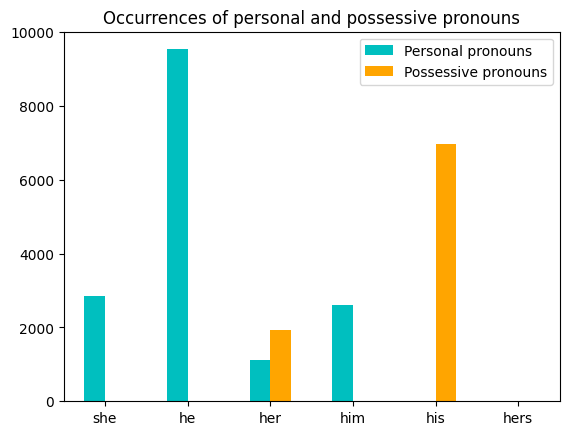

In [239]:
df_pronouns.plot(kind = "bar", color = ["c", "orange"])
plt.title("Occurrences of personal and possessive pronouns")
plt.xticks(rotation = 0)
plt.show()

The bar for "hers" is not visible because it has only 16 occurrences, and so it is very small with respect to the other pronouns.

g. Write a short text (200-300 words) and discuss the consequences of your findings. Why do you 
think the masculine pronoun is more frequent than the feminine pronoun? If you find that the 
there is a different distribution between nominative and object forms for the masculine and the
feminine pronouns, why do you think that is the case? Do you see any consequences for the development of language technology in general, and for language technology derived from 
example texts in particular? Make use of what you know about the Brown corpus.

I think that the masculine pronoun is more frequent than the feminine pronoun because of a factor of society and belief. This finding reflects gender biases, due to a patriarchal society. Moreover, when dealing with english language, if we want to talk about a person in a generic way (without any specification about gender), we generally use the masculine pronouns (and not the feminine ones).  65

For sure, there are consequences for the development of language technology. This is due to the fact that, when developing models, we train them with a bias, where masculine pronouns dominate over feminine pronouns. As a consequence, even the models will be affected by this bias, thus creating a vicious circle and renforcing stereotypes. 54

**Part 2 – Zipf’s law of abbreviation (30 pts)**

In [221]:
# Open the book file
f = open("book.txt", "r", encoding="utf-8-sig")
t = f.read()

a. You will see that the downloaded text contains a preamble and a long appendix about the 
Gutenberg project and copyrights. Load the file with Python and remove these parts so that you
only use the book text.

b. Tokenize the text, remove the punctuation marks, and produce a frequency distribution of the 
word lengths. Format this distribution as a Pandas dataframe.

In [222]:
# Tokenize the text
tokens = tok.word_tokenize(t, language = "english")
print(tokens[:30])

# Remove punctuation marks and put everything in lower case
tokens_new = [i.lower() for i in tokens if i.isalpha()]

# Produce frequency distribution of the word lenghts
d = {}
for word in tokens_new:
    word_length = len(word)
    if word_length in d:
        d[word_length] += 1
    else: 
        d[word_length] = 1
print(d)

# Format as a dataframe
df = pd.DataFrame(d.items(), columns=['Length', 'Frequency'])
df

['The', 'Project', 'Gutenberg', 'eBook', 'of', 'The', 'Adventures', 'of', 'Tom', 'Sawyer', ',', 'Complete', 'This', 'ebook', 'is', 'for', 'the', 'use', 'of', 'anyone', 'anywhere', 'in', 'the', 'United', 'States', 'and', 'most', 'other', 'parts', 'of']
{3: 19306, 7: 4137, 9: 1728, 5: 7788, 2: 11811, 10: 975, 6: 5458, 8: 2466, 4: 14523, 12: 230, 1: 4573, 13: 79, 11: 499, 15: 9, 14: 41, 16: 2}


,Length,Frequency
0,3,19306
1,7,4137
2,9,1728
3,5,7788
4,2,11811
5,10,975
6,6,5458
7,8,2466
8,4,14523
9,12,230


c. What are the five most frequent word lengths? How long are the longest words of the text?

In [88]:
# Sort the values by frequence and take the 5 highest values
print("The five most frequent word lengths are:")
print(df.sort_values("Frequency", ascending = False)[:5])

# Sort the values by length of the words and then take the maximum value
print("The length of the longest words of the text is:")
print(df.sort_values("Length").max()[0])
print("The number of words with this length is:")
print(df.sort_values("Length").max()[1])

The five most frequent word lengths are:
   Length  Frequency
0       3      19306
8       4      14523
4       2      11811
3       5       7788
6       6       5458
The length of the longest words of the text is:
16
The number of words with this length is:
19306


d. Order the table by word length and produce a plot that shows the frequencies.

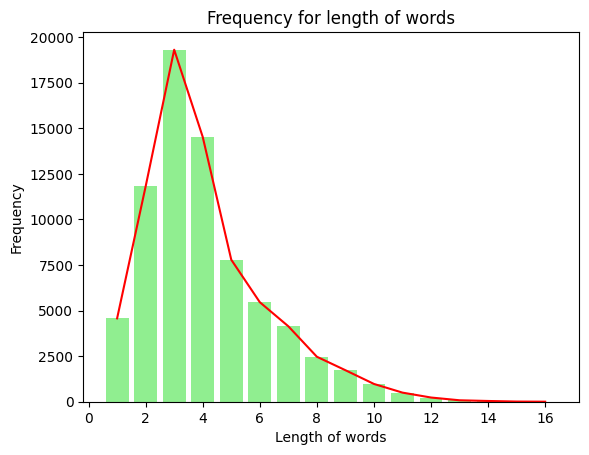

In [90]:
# Sort the values by length
df_length = df.sort_values("Length")

# Create the plot
plt.figure()
plt.plot(df_length.Length, df_length.Frequency, color = "r")
plt.bar(df_length.Length, df_length.Frequency, color = "lightgreen")
plt.xlabel("Length of words")
plt.ylabel("Frequency")
plt.title("Frequency for length of words")
plt.show()

e. Also produce a visualization with the data ordered by decreasing frequency.

    Length  Frequency
0        3      19306
8        4      14523
4        2      11811
3        5       7788
6        6       5458
10       1       4573
1        7       4137
7        8       2466
2        9       1728
5       10        975
12      11        499
9       12        230
11      13         79
14      14         41
13      15          9
15      16          2


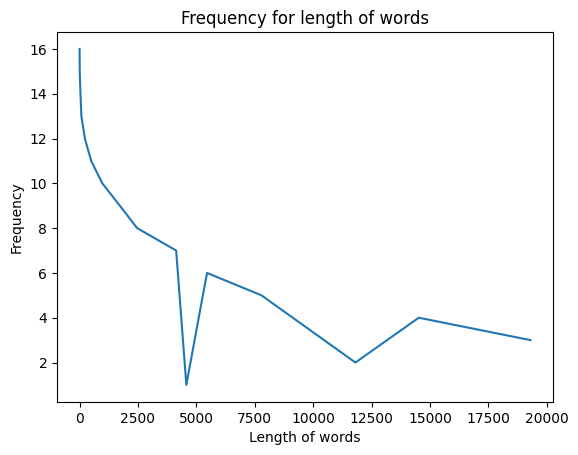

In [92]:
# Sort the values by decreasing frequency
df_freq = df.sort_values("Frequency", ascending = False)
print(df_freq)

# Create the plot
plt.figure()
plt.plot(df_freq.Frequency, df_freq.Length)
plt.xlabel("Length of words")
plt.ylabel("Frequency")
plt.title("Frequency for length of words")
plt.show()


f. When dealing with word frequency data, it is often recommended to plot frequencies on a 
logarithmic scale. How does this change the plots?


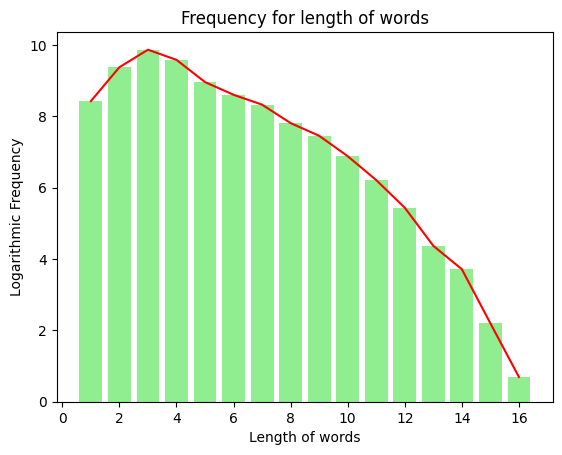

In [94]:
# Create the plot
plt.figure()
plt.plot(df_length.Length, np.log(df_length.Frequency), color = "r")
plt.bar(df_length.Length, np.log(df_length.Frequency), color = "lightgreen")
plt.xlabel("Length of words")
plt.ylabel("Logarithmic Frequency")
plt.title("Frequency for length of words")
plt.show()

The result is different from the previous one: the Logarithmic Frequency of the words tends to be more stable than the Frequency. It goes from 8 to 10 for the shortest words (from length 1 to length 3), and then it starts decreasing in a more constant way. While for the previous plot, the decrease of the curve was very sharp, more or less exponential.

g. How well does this dataset match Zipf’s law of abbreviation? In your opinion, which plot is most 
suitable to prove or disprove the law of abbreviation? Answer in text.

One of Zip's laws states that the length of a word is inversely correlated with its frequency. It seems that this behaviour can be seen also in this case, in particular for the words of length higher than or equal to 3. \\
In my opinion, the best plot to prove the law of abbreviation is the first one I created (without the logarithmic scale). That is because, with this graph I am able to understand well the relationship between length of words and frequency, proving that somehow the frequence decrease as the lenght increase.

h. Select one word length (maybe there are some outliers in the plots that you want to know more 
about?) and investigate in detail which words of this word length occur in the text. Are these 
words specific to the Tom Sawyer text, or would you expect them to occur similarly frequently in 
other English texts? Or is there any evidence of preprocessing (e.g. tokenization) errors?

I want to investigate more about the words of length 3, as their frequency is very high with respect to the others.

In [123]:
# Create a dictionary with all the words of length 3 and their frequencies
d = {}
for word in tokens_new:
    if len(word) == 3:
        if word not in d:
            d[word] = 1
        else:
            d[word] += 1

# Transform in a dataset and print it ordered by descending frequency
df_three = pd.DataFrame(d.items(), columns=["Word", "Frequency"])
df_three = df_three.sort_values("Frequency", ascending = False)
print(df_three[0:25])
print("------------------")
print("Total frequence:")
print(sum(df_three.Frequency))

   Word  Frequency
0   the       3938
4   and       3071
60  was       1164
5   you        907
13  his        819
1   tom        781
29  but        549
2   for        536
74  had        510
68  him        411
55  she        394
48  all        335
8   not        314
9   her        278
42  out        268
80  now        255
63  don        213
45  one        185
44  got        171
14  joe        164
89  any        153
59  did        138
62  see        135
67  can        132
22  boy        129
------------------
Total frequence:
19306


From this analysis, we can see that the most frequent words in this category are very common words in English. So, I suppose that this behavior is normal, and I expect to see a very high frequence for words of length 3 also in other English texts. Surely, the fact that the protagonist of the novel is called Tom increases the number of times words of this length appear in the text. However, the frequence for the word Tom is not so high (781), which is just arount the 4% of the total words of length three (which are 19306). So, the word Tom does not give a high contribution to this behavious, that is just a normal behaviour due to English language. 

In [127]:
print("""Percentage of \"Tom\" in the text, 
      with respect to all the words of length 3:""")
print(df_three.iloc[5][1]/sum(df_three.Frequency)*100)

Percentage of "Tom" in the text, with respect to all the words of length 3:
4.045374494975655


**Part 3 – Identifying dialogue act types in chat messages (35 pts)**


In [53]:
# Load the chat data into a Pandas dataframe 

nltk.download("nps_chat")
from nltk.corpus import nps_chat
data = []
for f in nps_chat.fileids():
    posts = nps_chat.xml_posts(f)
    for p in posts:
        data.append((p.get('class'), p.text))
df_chat = pd.DataFrame(data, columns=['label', 'text'])
print(df_chat.head(20))


[nltk_data] Downloading package nps_chat to
[nltk_data]     C:\Users\sanfe\AppData\Roaming\nltk_data...
[nltk_data]   Package nps_chat is already up-to-date!


         label                                         text
0    Statement               now im left with this gay name
1      Emotion                                           :P
2       System                                         PART
3        Greet                               hey everyone  
4    Statement                                      ah well
5       System                         NICK :10-19-20sUser7
6       Accept                10-19-20sUser7 is a gay name.
7       System  .ACTION gives 10-19-20sUser121 a golf clap.
8      Emotion                                           :)
9       System                                         JOIN
10       Greet                           hi 10-19-20sUser59
11   Statement   26/ m/ ky women that are nice please pm me
12      System                                         JOIN
13      System                                         PART
14   Statement                   there ya go 10-19-20sUser7
15      Reject                          

a. Answer the following questions:

• How many distinct labels are there, and how many instances per label?

In [51]:
# Number of distinct labels
print("Number of distinct labels:")
print(len(df_chat.label.unique()))

# Number of instances per label
print("Number of instances per label:")
print(df_chat.label.value_counts())

Number of distinct labels:
15
Number of instances per label:
Statement     3185
System        2632
Greet         1363
Emotion       1106
ynQuestion     550
whQuestion     533
Accept         233
Bye            195
Emphasis       190
Continuer      168
Reject         159
yAnswer        108
nAnswer         72
Clarify         38
Other           35
Name: label, dtype: int64


• Try to understand what the labels mean, looking at some examples if necessary.

Understanding of the labels:
- Statement: sentences where something is stated;
- System: system messages (they are mostly PART and JOIN);
- Greet: sentences with the aim of greeting someone;
- Emotion: expressions used to represents and reflects emotions;
- ynQuestion: questions which requires Yes or No as answers;
- whQuestion: questions starting with who, what, where, when or why;
- Accept: affermative answers or statments;
- Bye: sentences or expressions aimed at saying goodbye;
- Emphasis: sentences with exclamation marks, used to give emphasis to the message;
- Continuer: sentences used to continue other unfinished sentences (e. g. sentences containing and, or...);
- Reject: sentences with the aim or rejecting something or someone, or saying no;
- yAnswer: short sentences (maybe answers) with affirmative meaning;
- nAnswer: short sentences (maybe answers) with negative meaning;
- Clarify: adverbs, words or expressions used to clarify or correct something previously written;
- Other: numbers, symbols and other unclear expressions.

• What is the average message length (in characters)?

In [80]:
# Average message length (in characters), 
# taking into account also the spaces between words
l = []
for i in df_chat.text:
    l.append(len(i))
np.mean(l)

21.910570644459167

- How do these numbers compare to the Movie Reviews corpus used in the last exercise set?

In the Movie Reviews corpus used in the last exercise set, the average length of reviews was 3893.002, wery high in comparison to this case. I think it is mostly due to the fact that here we are talking about online chat conversations, where it is very common to write very short messages. On the contrary, for movies reviews, it is more natural to write a longer text.

• Explain in a few sentences how these differences may impact the text classification 
performance. Which text classification methods or parameter settings do you expect to 
be better adapted to the NPS Chat problem?

Replicate the multinomial Naïve Bayes system from the last exercise set. Concretely:

• Split the data into training and test data. To simplify things, we will just use a two-way split of 
90% training data and 10% test data in this first experiment.

In [84]:
x_train, x_test, y_train, y_test = train_test_split(df_chat["text"], 
                                                    df_chat["label"], 
                                                    test_size = 0.1)

• Instantiate a CountVectorizer with default parameters and fit it to the training data.

In [85]:
cv = CountVectorizer()
x_train_bow = cv.fit_transform(x_train)

• Instantiate a MultinomialNB model and fit it to the training data.

In [87]:
nb = MultinomialNB()
nb.fit(x_train_bow, y_train)

MultinomialNB()

• Predict the test set labels using the trained model and display the classification report.

In [91]:
x_test_bow = cv.transform(x_test)
predicted_y = nb.predict(x_test_bow)

print(metrics.classification_report(y_test, predicted_y))

              precision    recall  f1-score   support

      Accept       0.50      0.04      0.08        23
         Bye       0.78      0.30      0.44        23
     Clarify       0.00      0.00      0.00         3
   Continuer       0.00      0.00      0.00        17
     Emotion       0.87      0.68      0.76       104
    Emphasis       0.00      0.00      0.00        18
       Greet       0.68      0.93      0.78       138
       Other       0.00      0.00      0.00         1
      Reject       1.00      0.07      0.13        14
   Statement       0.58      0.84      0.68       323
      System       0.91      0.96      0.93       255
     nAnswer       0.00      0.00      0.00        16
  whQuestion       0.86      0.22      0.35        55
     yAnswer       0.00      0.00      0.00        14
  ynQuestion       0.50      0.15      0.23        53

    accuracy                           0.70      1057
   macro avg       0.44      0.28      0.29      1057
weighted avg       0.68   

c:\Users\sanfe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sanfe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sanfe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

b. Write a few lines about your observations: Which classes are the easiest / most difficult to predict? 

The most difficult classes to predict are nAnswer, Emphasis and Other with both precision and recall equal to 0.

Are there classes where precision differs drastically from recall, and if so, what does this 
mean?


There are some classes where precision and recall are drastically different. These classes are: Accept, Bye, whQuestion, Reject, especially the last one. In particular, for these classes, precision is very high with respect to recall. This means that the model has high probability of being right when predicting a positive value, while it has low probability of identifying correctly all the positives.

c. Produce the cross-validation scores with the initial Naïve Bayes model.

In [102]:
x_train, x_test, y_train, y_test = train_test_split(df_chat["text"], 
                                                    df_chat["label"], 
                                                    test_size = 0.1)

cv = CountVectorizer()
x_train_bow = cv.fit_transform(x_train)

nb = MultinomialNB()
nb.fit(x_train_bow, y_train)

x_test_bow = cv.transform(x_test)
predicted_y = nb.predict(x_test_bow)

# Five-fold cross-validation
scores = cross_val_score(nb, x_train_bow, y_train, cv=5)
print("{:.3f} accuracy with a standard deviation of {:.3f}".format(scores.mean(), 
                                                                   scores.std()))

0.703 accuracy with a standard deviation of 0.007


d. By default, the CountVectorizer lowercases all input and uses a simple whitespace-based 
tokenizer. Check if other settings provide better results.

In [120]:
cv = CountVectorizer(stop_words = "english")
x_train_bow = cv.fit_transform(x_train)

nb = MultinomialNB()
nb.fit(x_train_bow, y_train)

x_test_bow = cv.transform(x_test)
predicted_y = nb.predict(x_test_bow)

# Five-fold cross-validation
scores = cross_val_score(nb, x_train_bow, y_train, cv=5)
print("{:.3f} accuracy with a standard deviation of {:.3f}".format(scores.mean(), 
                                                                   scores.std()))

0.560 accuracy with a standard deviation of 0.009


The use of a built-in stop word list for English decreases a lot the accuracy of the model, which resuls to be way worse than before.

e. By default (and as its name implies), the CountVectorizer produces frequency counts. Evaluate 
the impact of binary feature values (presence or absence of a word in an instance). 

In [125]:
cv = CountVectorizer(binary = True)
x_train_bow = cv.fit_transform(x_train)

nb = MultinomialNB()
nb.fit(x_train_bow, y_train)

x_test_bow = cv.transform(x_test)
predicted_y = nb.predict(x_test_bow)

# Five-fold cross-validation
scores = cross_val_score(nb, x_train_bow, y_train, cv=5)
print("{:.3f} accuracy with a standard deviation of {:.3f}".format(scores.mean(), 
                                                                   scores.std()))

0.704 accuracy with a standard deviation of 0.006


The set of binary property from False (default) to True (i.e. all non zero counts are set to 1) in the CountVectorizer allows to obtain a model whose accuracy is very similar to the first model (even a little bit better).

There is a 
second way to include binary features, namely by using the BernoulliNB model instead of the 
MultinomialNB one. What is the difference between the binary multinomial model and the 
Bernoulli model (both in terms of scores and theoretically)?

Theoretically, the difference between Multinomial and Bernoulli NB is that Multinomial NB uses count-based bags of words (you count how many times a word is present in a text), while Bernoulli NB uses binary counts (you register only whether a tern is present or not in a text: 1 if it present, 0 if it is not present). As a consequence, Multinomial NB considers only the presents terms, ignoring absent terms. On the contrary, Bernoulli NB considers both the present and the absent terms.

In [129]:
cv = CountVectorizer()
x_train_bow = cv.fit_transform(x_train)

nb = BernoulliNB()
nb.fit(x_train_bow, y_train)

x_test_bow = cv.transform(x_test)
predicted_y = nb.predict(x_test_bow)

# Five-fold cross-validation
scores = cross_val_score(nb, x_train_bow, y_train, cv=5)
print("{:.3f} accuracy with a standard deviation of {:.3f}".format(scores.mean(), 
                                                                   scores.std()))

0.633 accuracy with a standard deviation of 0.011


It seems that the Bernoulli NB produces a worse result in this case.

f. We know that Logistic Regression may produce better results than Naive Bayes. We will see 
what happens if we use Logistic Regression instead of Naive Bayes on this task. Keep the same 
CountVectorizer as before and replace the Naïve Bayes classifier by a Logistic Regression one 
with default parameters.

You may have to revisit the count/binary features distinction and the case folding parameter as 
this is a different type of classifier.

In [146]:
cv = CountVectorizer()
x_train_bow = cv.fit_transform(x_train)

lr = LogisticRegression()
lr.fit(x_train_bow, y_train)

x_test_bow = cv.transform(x_test)
predicted_y = lr.predict(x_test_bow)

# Five-fold cross-validation
scores = cross_val_score(lr, x_train_bow, y_train, cv=5)
print("{:.3f} accuracy with a standard deviation of {:.3f}".format(scores.mean(), 
                                                                   scores.std()))

c:\Users\sanfe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\sanfe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\sanfe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed i

0.736 accuracy with a standard deviation of 0.007


c:\Users\sanfe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


g. Evaluate different regularization settings (L2, L1, different values of C). The supported types of 
regularization depend on the Solver used for gradient descent. The documentation provides 
more details about the different available solvers:
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
Note that the solvers provided with Scikit-Learn determine the learning rate on their own, so 
there is not parameter to set a specific learning rate.


In [134]:
cv = CountVectorizer()
x_train_bow = cv.fit_transform(x_train)

lr = LogisticRegression(solver = "liblinear")
lr.fit(x_train_bow, y_train)

x_test_bow = cv.transform(x_test)
predicted_y = lr.predict(x_test_bow)

# Five-fold cross-validation
scores = cross_val_score(lr, x_train_bow, y_train, cv=5)
print("{:.3f} accuracy with a standard deviation of {:.3f}".format(scores.mean(), 
                                                                   scores.std()))

0.776 accuracy with a standard deviation of 0.008


In [157]:
cv = CountVectorizer()
x_train_bow = cv.fit_transform(x_train)

lr = LogisticRegression(penalty = "l1",solver = "liblinear")
lr.fit(x_train_bow, y_train)

x_test_bow = cv.transform(x_test)
predicted_y = lr.predict(x_test_bow)

# Five-fold cross-validation
scores = cross_val_score(lr, x_train_bow, y_train, cv=5)
print("{:.3f} accuracy with a standard deviation of {:.3f}".format(scores.mean(), 
                                                                   scores.std()))

0.775 accuracy with a standard deviation of 0.007


In [142]:
cv = CountVectorizer()
x_train_bow = cv.fit_transform(x_train)

lr = LogisticRegression(solver = "liblinear", C = 4.0)
lr.fit(x_train_bow, y_train)

x_test_bow = cv.transform(x_test)
predicted_y = lr.predict(x_test_bow)

# Five-fold cross-validation
scores = cross_val_score(lr, x_train_bow, y_train, cv=5)
print("{:.3f} accuracy with a standard deviation of {:.3f}".format(scores.mean(), 
                                                                   scores.std()))

0.780 accuracy with a standard deviation of 0.005


This last model results to be the model with the highest accuracy.

h. Retrain the best model on the entire training set and evaluate it on the test set. Report the 
detailed evaluation scores and compare them with the initial Naïve Bayes scores. On which 
classes did your model improve the most? Which classes are still difficult to predict?